In [2]:
# 모델의 구성 정보를 YAML 파일로 저장합니다.
project_dir = "/data/ephemeral/home/nlp-5/auto1p/" # 본인 경로에 맞게 설정
import os
import sys
sys.path.append(
    project_dir
)
from src.utils.utils import *

import pandas as pd
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

train_df = pd.read_csv(os.path.join(project_dir, 'data','train.csv'))
val_df = pd.read_csv(os.path.join(project_dir, 'data','dev.csv'))
test_df = pd.read_csv(os.path.join(project_dir, 'data','test.csv'))
# sub_df = pd.read_csv(os.path.join(project_dir, 'data','submission_best.csv'))
sub_df = pd.read_csv(os.path.join(project_dir, 'outputs', 'exp_bart_08021533','submission_08021533.csv'))

# train_solar_en2ko = pd.read_csv(os.path.join(project_dir, 'data','train_solar_backtranslate_en2ko.csv'))

In [4]:
test_df['summary'] = sub_df['summary']

- load lenizer

In [5]:
from transformers import AutoTokenizer, BartForConditionalGeneration, BartConfig, AutoModelForSeq2SeqLM, AutoConfig
# model_name = "csebuetnlp/mT5_multilingual_XLSum"
model_name = "upstage/solar-pro2-tokenizer"

# bart_config = BartConfig().from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = BartForConditionalGeneration.from_pretrained(model_name, config=bart_config)
# config = AutoConfig.from_pretrained(model_name)
# model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

- tokenized된 대화문, 요약문의 길이 분포 분석

In [6]:
train_df.columns

Index(['fname', 'dialogue', 'summary', 'topic'], dtype='object')

## 문자열 길이로 분석

In [7]:
from tqdm import tqdm
tqdm.pandas()
# Apply tokenization and count tokens to 'dialogue' and 'summary' columns
print("Processing train_df...")
train_df['dialogue_len_count'] = train_df['dialogue'].progress_apply(len)
train_df['summary_len_count'] = train_df['summary'].progress_apply(len)

print("\nProcessing val_df...")
val_df['dialogue_len_count'] = val_df['dialogue'].progress_apply(len)
val_df['summary_len_count'] = val_df['summary'].progress_apply(len)

print("\nProcessing test_df...")
test_df['dialogue_len_count'] = test_df['dialogue'].progress_apply(len)
test_df['summary_len_count'] = test_df['summary'].progress_apply(len)

# print("\nProcessing train_solars...")
# train_solar_en2ko['dialogue_len_count'] = train_solar_en2ko['dialogue'].progress_apply(len)
# train_solar_en2ko['summary_len_count'] = train_solar_en2ko['summary'].progress_apply(len)


Processing train_df...


100%|██████████| 12457/12457 [00:00<00:00, 1716891.59it/s]



Processing val_df...


100%|██████████| 499/499 [00:00<00:00, 707319.26it/s]



Processing test_df...


100%|██████████| 499/499 [00:00<00:00, 645974.60it/s]


In [8]:
train_df['len_compress_ratio'] = train_df['summary_len_count'] / train_df['dialogue_len_count']
val_df['len_compress_ratio'] = val_df['summary_len_count'] / val_df['dialogue_len_count']
test_df['len_compress_ratio'] = test_df['summary_len_count'] / test_df['dialogue_len_count']
# train_solar_en2ko['len_compress_ratio'] = train_solar_en2ko['summary_len_count'] / train_solar_en2ko['dialogue_len_count']

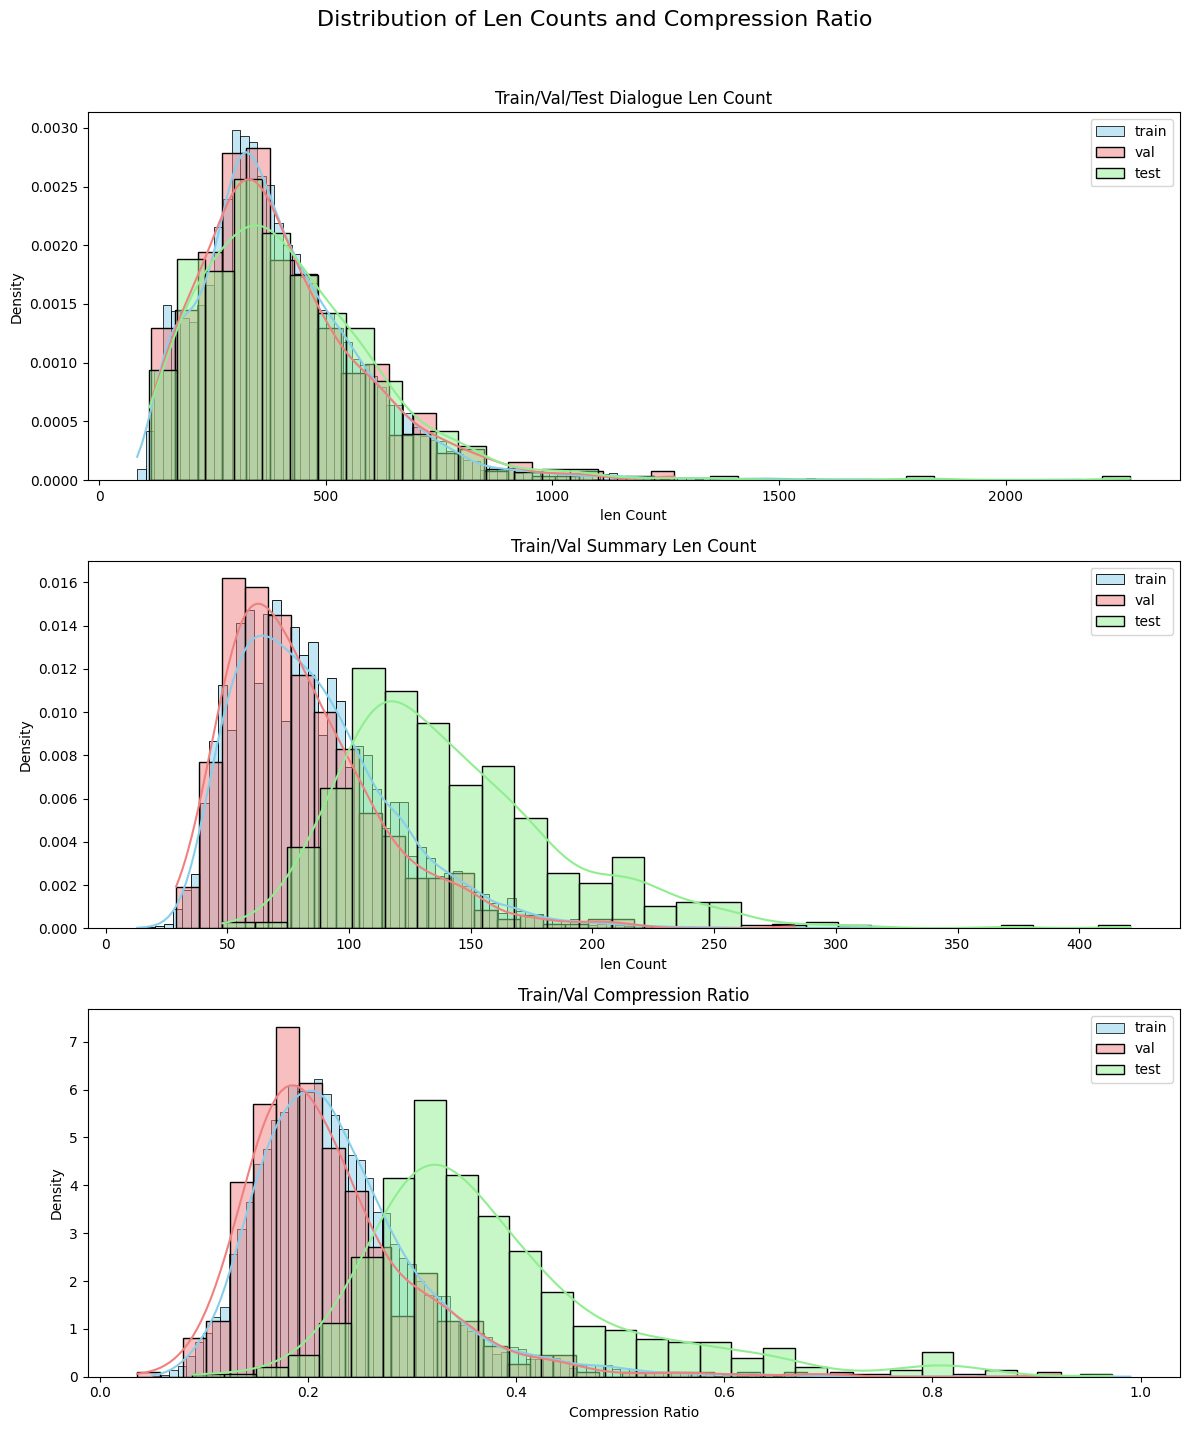

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
# Set up the figure and axes for subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 15))
fig.suptitle('Distribution of Len Counts and Compression Ratio', fontsize=16)

# Plot for dialogue_len_count
sns.histplot(train_df['dialogue_len_count'], kde=True, ax=axes[0], color='skyblue', stat='density', label='train')
sns.histplot(val_df['dialogue_len_count'], kde=True, ax=axes[0], color='lightcoral', stat='density', label='val')
sns.histplot(test_df['dialogue_len_count'], kde=True, ax=axes[0], color='lightgreen', stat='density', label='test')
# sns.histplot(train_solar_en2ko['dialogue_len_count'], kde=True, ax=axes[0], color='lightgray', stat='density', label='train_solar')
axes[0].set_title('Train/Val/Test Dialogue Len Count')
axes[0].set_xlabel('len Count')
axes[0].set_ylabel('Density')
axes[0].legend()

sns.histplot(train_df['summary_len_count'], kde=True, ax=axes[1], color='skyblue', stat='density', label='train')
sns.histplot(val_df['summary_len_count'], kde=True, ax=axes[1], color='lightcoral', stat='density', label='val')
sns.histplot(test_df['summary_len_count'], kde=True, ax=axes[1], color='lightgreen', stat='density', label='test')
# sns.histplot(train_solar_en2ko['summary_len_count'], kde=True, ax=axes[1], color='lightgray', stat='density', label='train_solar')
axes[1].set_title('Train/Val Summary Len Count')
axes[1].set_xlabel('len Count')
axes[1].set_ylabel('Density')
axes[1].legend()

sns.histplot(train_df['len_compress_ratio'], kde=True, ax=axes[2], color='skyblue', stat='density', label='train')
sns.histplot(val_df['len_compress_ratio'], kde=True, ax=axes[2], color='lightcoral', stat='density', label='val')
sns.histplot(test_df['len_compress_ratio'], kde=True, ax=axes[2], color='lightgreen', stat='density', label='test')
# sns.histplot(train_solar_en2ko['len_compress_ratio'], kde=True, ax=axes[2], color='lightgray', stat='density', label='train_solar')
axes[2].set_title('Train/Val Compression Ratio')
axes[2].set_xlabel('Compression Ratio')
axes[2].set_ylabel('Density')
axes[2].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # Adjust layout to prevent title overlap
plt.show()

In [10]:
# sns.histplot(train_solar_en2ko['len_compress_ratio'], kde=True, color='lightgray', stat='density', label='test')
# plt.show()

## 토큰화 후 길이 분석

In [11]:
from tqdm import tqdm
tqdm.pandas()
def count_tokens(text, tokenizer):
    return len(tokenizer.encode(text, add_special_tokens=True))
# Apply tokenization and count tokens to 'dialogue' and 'summary' columns
print("Processing train_df...")
train_df['dialogue_token_count'] = train_df['dialogue'].progress_apply(lambda x: count_tokens(x, tokenizer))
train_df['summary_token_count'] = train_df['summary'].progress_apply(lambda x: count_tokens(x, tokenizer))

print("\nProcessing val_df...")
val_df['dialogue_token_count'] = val_df['dialogue'].progress_apply(lambda x: count_tokens(x, tokenizer))
val_df['summary_token_count'] = val_df['summary'].progress_apply(lambda x: count_tokens(x, tokenizer))

print("\nProcessing test_df...")
test_df['dialogue_token_count'] = test_df['dialogue'].progress_apply(lambda x: count_tokens(x, tokenizer))
test_df['summary_token_count'] = test_df['summary'].progress_apply(lambda x: count_tokens(x, tokenizer))

# print("\nProcessing train_solar...")
# train_solar_en2ko['dialogue_token_count'] = train_solar_en2ko['dialogue'].progress_apply(lambda x: count_tokens(x, tokenizer))
# train_solar_en2ko['summary_token_count'] = train_solar_en2ko['summary'].progress_apply(lambda x: count_tokens(x, tokenizer))


Processing train_df...


100%|██████████| 12457/12457 [00:01<00:00, 11999.60it/s]



Processing val_df...


100%|██████████| 499/499 [00:00<00:00, 12271.02it/s]



Processing test_df...


100%|██████████| 499/499 [00:00<00:00, 8081.07it/s]


In [12]:
train_df['compress_ratio'] = train_df['summary_token_count'] / train_df['dialogue_token_count']
val_df['compress_ratio'] = val_df['summary_token_count'] / val_df['dialogue_token_count']
test_df['compress_ratio'] = test_df['summary_token_count'] / test_df['dialogue_token_count']
# train_solar_en2ko['compress_ratio'] = train_solar_en2ko['summary_token_count'] / train_solar_en2ko['dialogue_token_count']

#### 토큰 길이 분포 - 히스토그램

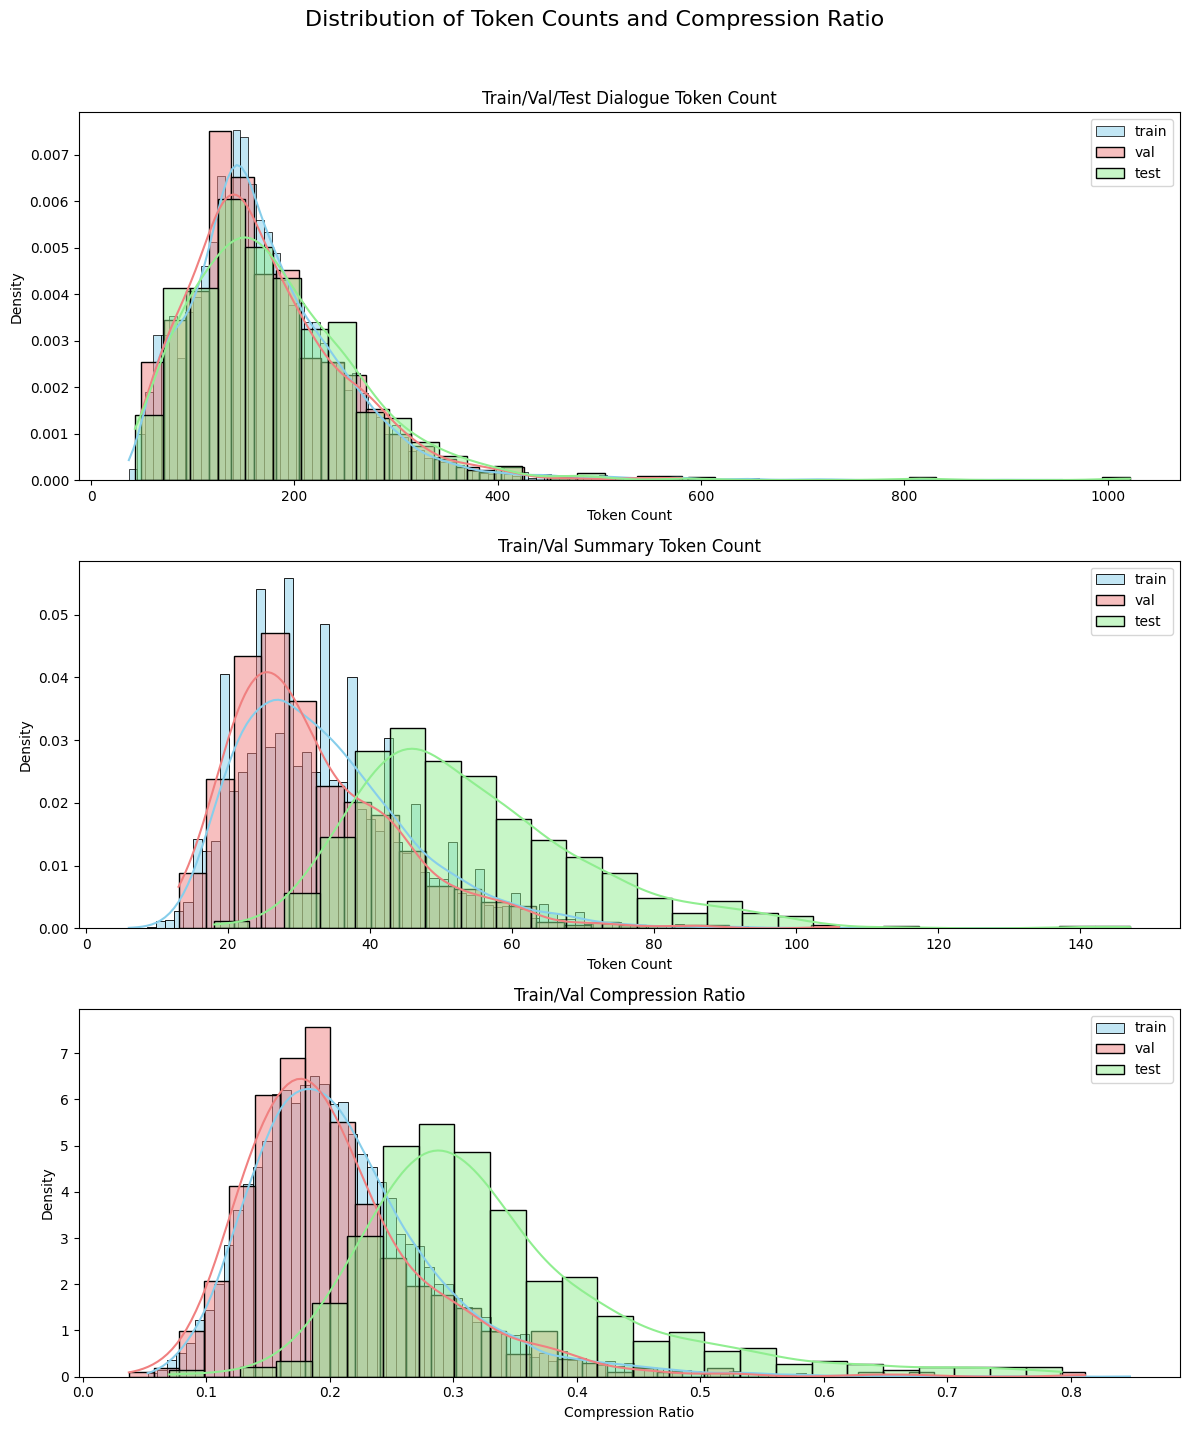

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
# Set up the figure and axes for subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 15))
fig.suptitle('Distribution of Token Counts and Compression Ratio', fontsize=16)

# Plot for dialogue_token_count
sns.histplot(train_df['dialogue_token_count'], kde=True, ax=axes[0], color='skyblue', stat='density', label='train')
sns.histplot(val_df['dialogue_token_count'], kde=True, ax=axes[0], color='lightcoral', stat='density', label='val')
sns.histplot(test_df['dialogue_token_count'], kde=True, ax=axes[0], color='lightgreen', stat='density', label='test')
# sns.histplot(train_solar_en2ko['dialogue_token_count'], kde=True, ax=axes[0], color='lightgray', stat='density', label='train_solar')
axes[0].set_title('Train/Val/Test Dialogue Token Count')
axes[0].set_xlabel('Token Count')
axes[0].set_ylabel('Density')
axes[0].legend()

sns.histplot(train_df['summary_token_count'], kde=True, ax=axes[1], color='skyblue', stat='density', label='train')
sns.histplot(val_df['summary_token_count'], kde=True, ax=axes[1], color='lightcoral', stat='density', label='val')
sns.histplot(test_df['summary_token_count'], kde=True, ax=axes[1], color='lightgreen', stat='density', label='test')
# sns.histplot(train_solar_en2ko['summary_token_count'], kde=True, ax=axes[1], color='lightgray', stat='density', label='train_solar')
axes[1].set_title('Train/Val Summary Token Count')
axes[1].set_xlabel('Token Count')
axes[1].set_ylabel('Density')
axes[1].legend()

sns.histplot(train_df['compress_ratio'], kde=True, ax=axes[2], color='skyblue', stat='density', label='train')
sns.histplot(val_df['compress_ratio'], kde=True, ax=axes[2], color='lightcoral', stat='density', label='val')
sns.histplot(test_df['compress_ratio'], kde=True, ax=axes[2], color='lightgreen', stat='density', label='test')
# sns.histplot(train_solar_en2ko['compress_ratio'], kde=True, ax=axes[2], color='lightgray', stat='density', label='train_solar')
axes[2].set_title('Train/Val Compression Ratio')
axes[2].set_xlabel('Compression Ratio')
axes[2].set_ylabel('Density')
axes[2].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # Adjust layout to prevent title overlap
plt.show()

In [14]:
# fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 6))
# fig.suptitle('Distribution of Token Counts and Compression Ratio', fontsize=16)
# sns.histplot(train_solar_en2ko['summary_token_count'], kde=True, ax=axes[0], color='green', stat='density')
# axes[0].set_title('Test Summary Token Count')
# axes[0].set_xlabel('Token Count')
# axes[0].set_ylabel('Density')

# sns.histplot(train_solar_en2ko['compress_ratio'], kde=True, ax=axes[1], color='green', stat='density')
# axes[1].set_title('Train/Val Compression Ratio')
# axes[1].set_xlabel('Compression Ratio')
# axes[1].set_ylabel('Density')

# plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # Adjust layout to prevent title overlap
# plt.show()

#### 토큰 길이 분석 - 상관관계 분석

In [15]:
from scipy.stats import pearsonr

def analyze_and_plot(df, title, ax, color):
    # Calculate outliers based on compression ratio
    lower_bound = df['compress_ratio'].quantile(0.01)
    upper_bound = df['compress_ratio'].quantile(0.99)

    # Identify outlier points
    outliers = df[(df['compress_ratio'] <= lower_bound) | (df['compress_ratio'] >= upper_bound)]
    non_outliers = df[(df['compress_ratio'] > lower_bound) & (df['compress_ratio'] < upper_bound)]

    # Plot non-outliers first
    sns.regplot(x='dialogue_token_count', y='summary_token_count', data=non_outliers,
                ax=ax, scatter_kws={'alpha':0.6, 's':20}, line_kws={'color':color}, ) #label='Normal Points')

    # Plot outliers in red
    if not outliers.empty:
        sns.scatterplot(x='dialogue_token_count', y='summary_token_count', data=outliers,
                        ax=ax, color='red', s=40, ) #label='Outliers (Comp. Ratio <1% or >99%)')

    ax.set_title(title)
    ax.set_xlabel('Dialogue Token Count')
    ax.set_ylabel('Summary Token Count')
    # ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

    # Calculate Pearson correlation coefficient and p-value
    corr, p_value = pearsonr(df['dialogue_token_count'], df['summary_token_count'])
    print(f"\n--- {title} ---")
    print(f"Pearson Correlation Coefficient: {corr:.4f}")
    print(f"P-value: {p_value:.4f}")


--- Train Dataset ---
Pearson Correlation Coefficient: 0.6729
P-value: 0.0000

--- Validation Dataset ---
Pearson Correlation Coefficient: 0.6624
P-value: 0.0000

--- Test Dataset ---
Pearson Correlation Coefficient: 0.7884
P-value: 0.0000


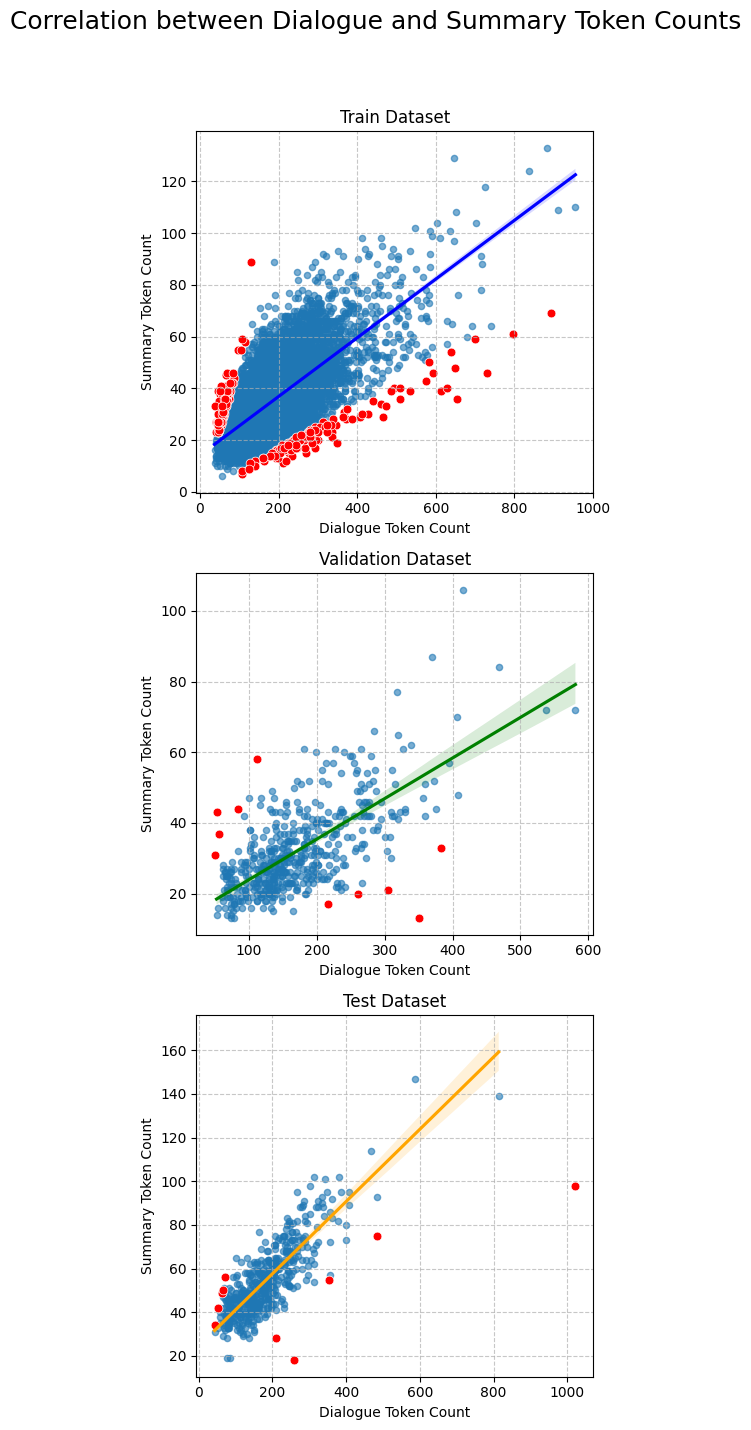

In [17]:
# Create subplots for visualization
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(5, 15))
fig.suptitle('Correlation between Dialogue and Summary Token Counts', fontsize=18, y=0.98)

# Analyze and plot for train_df
analyze_and_plot(train_df, 'Train Dataset', axes[0], 'blue')

# Analyze and plot for val_df
analyze_and_plot(val_df, 'Validation Dataset', axes[1], 'green')

# Analyze and plot for test_df
analyze_and_plot(test_df, 'Test Dataset', axes[2], 'orange')

# Analyze and plot for train_solar
# analyze_and_plot(train_solar_en2ko, 'Train-Solar Dataset', axes[3], 'gray')

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()

## 모듈

- 46점짜리 submission의 경우 dialogue-summary 길이 상관계수가 0.018 정도에 p-value 0.8이었는데, 48점짜리는 토큰 길이 분포는 큰 차이가 없지만 dial-sum 길이 상관계수가 0.05 정도에 p-value도 0.2수준으로 크게 낮아짐.
   > 즉, dial-sum 상관계수가 높을수록 좋은 점수를 받을 가능성 증가함.

## Train-Solar 정제

In [77]:
print(train_solar_en2ko.shape[0])

12457


In [82]:
# 가장 작은 길이의 dialogue
min_token_counts = train_solar_en2ko['dialogue_token_count'].min()
print(min_token_counts)
error_index_min_token_counts = train_solar_en2ko[train_solar_en2ko['dialogue_token_count']==min_token_counts].index
print("error counts:", len(error_index_min_token_counts))
print(train_solar_en2ko.iloc[error_index_min_token_counts]['dialogue']) # >> 명백한 오류

# 해당 dialogue 제거
train_solar_en2ko_cleaned = train_solar_en2ko.drop(error_index_min_token_counts)

print(train_solar_en2ko_cleaned.shape[0])

4
error counts: 1
8921    주어진 대화 번역 :
Name: dialogue, dtype: object
12456


In [83]:
# #Person1# 으로 시작하지 않는 dialogue들의 경우도 오류에 해당.
def startswith_person1(dialogue):
    if dialogue.strip().startswith("#Person1#:"):
        return True
    return False
train_solar_en2ko_cleaned['person1'] = train_solar_en2ko_cleaned['dialogue'].progress_apply(startswith_person1)

print("error counts:", len(train_solar_en2ko_cleaned[train_solar_en2ko_cleaned['person1'] == False]))

train_solar_en2ko_cleaned = train_solar_en2ko_cleaned[train_solar_en2ko_cleaned['person1']==True]
train_solar_en2ko_cleaned.drop(columns=['person1'], inplace=True)
print(train_solar_en2ko_cleaned.shape[0])

100%|██████████| 12456/12456 [00:00<00:00, 735109.76it/s]

error counts: 0
12456


In [84]:
# compression ratio가 상위99, 하위1% 밖의 이상치들 확인
lower_bound = train_solar_en2ko_cleaned['compress_ratio'].quantile(0.01)
upper_bound = train_solar_en2ko_cleaned['compress_ratio'].quantile(0.99)
print(lower_bound, upper_bound)
print(train_solar_en2ko_cleaned['compress_ratio'].max(), train_solar_en2ko_cleaned['compress_ratio'].min())

0.16666666666666666 1.0197605965463117
1.5625 0.07722007722007722


## Train & Train-Solar 병합


### 버전1: 단순 concat

In [162]:
train_solar_en2ko_cleaned.columns

Index(['fname', 'dialogue', 'summary', 'ner', 'topic', 'dialogue_len_count',
       'summary_len_count', 'len_compress_ratio', 'dialogue_token_count',
       'summary_token_count', 'compress_ratio'],
      dtype='object')

In [163]:
columns_to_concat = ['fname','dialogue','summary','topic']
train_aug_v1 = pd.concat([
    train_df[columns_to_concat], train_solar_en2ko_cleaned[columns_to_concat]
])
display(train_aug_v1.head(1))
display(train_aug_v1.tail(1))
train_aug_v1.reset_index(drop=True, inplace=True)
train_aug_v1['fname'] = list(map(lambda x: f"train_{x}", train_aug_v1.index))
display(train_aug_v1.head(1))
display(train_aug_v1.tail(1))


,fname,dialogue,summary,topic
0,train_0,"#Person1#: 안녕하세요, Mr. Smith. 저는 Dr. Hawkins입니다...","Mr. Smith는 Dr. Hawkins에게 건강검진을 받으러 와서, 매년 검진 필...",건강검진


,fname,dialogue,summary,topic
12456,train_12459,"#Person1#: 엄마, 다음 주 토요일에 이모부 가족한테 놀러 갈 거예요. 오늘...",#Person1#이 다음 주 토요일 이모부 가족 방문 시 가방 준비를 위해 옷을 문...,여행 준비 및 방문 계획


,fname,dialogue,summary,topic
0,train_0,"#Person1#: 안녕하세요, Mr. Smith. 저는 Dr. Hawkins입니다...","Mr. Smith는 Dr. Hawkins에게 건강검진을 받으러 와서, 매년 검진 필...",건강검진


,fname,dialogue,summary,topic
24912,train_24912,"#Person1#: 엄마, 다음 주 토요일에 이모부 가족한테 놀러 갈 거예요. 오늘...",#Person1#이 다음 주 토요일 이모부 가족 방문 시 가방 준비를 위해 옷을 문...,여행 준비 및 방문 계획


In [164]:
print(train_aug_v1.shape)
train_aug_v1.to_csv(os.path.join(project_dir,'data','train_aug_v1.csv'),index=False)

(24913, 4)


### 버전2 : Mixup

In [100]:
d_origin_s_origin = train_df[['fname','dialogue','summary','topic']].copy()
d_solar_s_origin = train_solar_en2ko_cleaned[['fname','dialogue','ner']].merge(right=train_df[['fname','summary','topic']], on='fname', how='left').copy()
d_solar_s_solar = train_solar_en2ko_cleaned[['fname','dialogue','summary','topic']].copy()
d_origin_s_solar = train_solar_en2ko_cleaned[['fname','summary','ner']].merge(right=train_df[['fname','dialogue','topic']], on='fname', how='left').copy()

In [101]:
d_solar_s_origin.head()

,fname,dialogue,ner,summary,topic
0,train_0,"#Person1#: 안녕하세요, 스미스 씨. 저는 호킨스 박사입니다. 오늘 무슨 일...","Mr. Smith, Dr. Hawkins","Mr. Smith는 Dr. Hawkins에게 건강검진을 받으러 와서, 매년 검진 필...",건강검진
1,train_1,"#Person1#: 안녕하세요, 파커 여사. 어떻게 지내셨나요? \n#Person...","Mrs. Parker, Dr. Peters, Ricky, 소아마비, 파상풍, B형 ...","Mrs. Parker가 Ricky와 함께 백신 접종을 위해 방문하였고, Dr. Pe...",백신 접종
2,train_2,"#Person1#: 실례합니다, 열쇠 꾸러미를 보셨나요? \n#Person2#: ...",Named Entities:,#Person1#은 열쇠 세트를 잃어버리고 #Person2#에게 찾는 것을 도와달라...,열쇠 분실
3,train_3,#Person1#: 왜 여자친구가 있다는 걸 나한테 말하지 않았어? \n#Pers...,The dialogue does not contain any named entiti...,#Person1#은 #Person2#가 여자친구가 있고 결혼할 예정이라는 사실을 말...,여자친구와의 결혼
4,train_4,"#Person1#: 안녕하세요, 오늘 정말 멋져 보여요. 저랑 춤 한 번 추시겠어요...","Malik, Wen, Nikki","Malik은 Wen과 Nikki에게 춤을 제안하고, Wen은 발을 밟는 것을 감수하...",춤 제안


In [102]:
d_origin_s_solar.head()

,fname,summary,ner,dialogue,topic
0,train_0,"호킨스 박사는 스미스 씨의 건강 검진을 진행하며, 5년간 검진을 받지 않은 점을 지...","Mr. Smith, Dr. Hawkins","#Person1#: 안녕하세요, Mr. Smith. 저는 Dr. Hawkins입니다...",건강검진
1,train_1,"피터스 박사는 파커 여사와 리키의 예방접종 상담을 진행한다. 리키는 소아마비, 파상...","Mrs. Parker, Dr. Peters, Ricky, 소아마비, 파상풍, B형 ...","#Person1#: 안녕하세요, Mrs. Parker. 잘 지내셨나요?\n#Pers...",백신 접종
2,train_2,#Person1#이 열쇠 5개와 발 모양 장식이 달린 열쇠 꾸러미를 찾고 있다고 말...,Named Entities:,"#Person1#: 저기요, 열쇠 세트 본 적 있어요?\n#Person2#: 어떤 ...",열쇠 분실
3,train_3,#Person1#은 #Person2#가 여자친구 존재와 결혼 계획을 미리 알리지 않...,The dialogue does not contain any named entiti...,#Person1#: 너 여자친구 있는 거 왜 말 안 했어?\n#Person2#: 미...,여자친구와의 결혼
4,train_4,Malik이 Wen과 Nikki에게 춤을 제안하며 자신을 소개합니다. Wen은 춤을...,"Malik, Wen, Nikki","#Person1#: 안녕, 오늘 너무 멋져 보이네요. 저랑 춤 한 곡 추실래요?\n...",춤 제안


In [117]:
unique_ner = []
for value in tqdm(train_solar_en2ko_cleaned['ner']):
    values = value.split(",") # 쉽표로 구분
    values = list(map(str.strip, values)) # strip 적용
    unique_ner.extend(values)
unique_ner = set(unique_ner)
print(len(unique_ner))

100%|██████████| 12456/12456 [00:00<00:00, 1056036.76it/s]

15446


In [147]:
# unique_ner 세트에서 3단어 이하의 문자열 추출
three_words_or_less_ner = set()
for item in tqdm(unique_ner):
    if (':' not in item) and len(item.split()) <= 3: # ':"를 포함하지 않고, 3단어 이하인 ner만 추출
        three_words_or_less_ner.add(item)
print(f"3단어 이하의 문자열을 포함하는 unique_ner 세트의 크기: {len(three_words_or_less_ner)}")

100%|██████████| 15446/15446 [00:00<00:00, 1797342.75it/s]

3단어 이하의 문자열을 포함하는 unique_ner 세트의 크기: 13704


In [151]:
from transformers import MBartForConditionalGeneration, MBart50TokenizerFast

en_input = "Bjok"

model = MBartForConditionalGeneration.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")
tokenizer = MBart50TokenizerFast.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")

# translate Hindi to French
tokenizer.src_lang = "en_XX"
encoded = tokenizer(en_input, return_tensors="pt")
generated_tokens = model.generate(
    **encoded,
    forced_bos_token_id=tokenizer.lang_code_to_id["ko_KR"]
)
ko_output = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
print(ko_output)


['비요크']


In [ ]:
import re
from multiprocessing import Pool, Manager # Manager는 공유 딕셔너리를 위해 필요
global_model = None
global_tokenizer = None
# 번역된 개체명 쌍을 저장할 딕셔너리 초기화
match_en_ko_dict = {}
def init_worker():
    """
    각 프로세스가 시작될 때 모델과 토크나이저를 로드하는 함수
    """
    global global_model, global_tokenizer
    if global_model is None: # 이미 로드된 경우 다시 로드하지 않음
        print(f"[{os.getpid()}] 모델 및 토크나이저 로드 중...")
        global_model = MBartForConditionalGeneration.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")
        global_tokenizer = MBart50TokenizerFast.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")
        print(f"[{os.getpid()}] 로드 완료.")

# 문자열에 한국어 문자가 포함되어 있는지 확인하는 함수
def contains_english(text):
    """
    주어진 텍스트에 영어 알파벳(대소문자)이 포함되어 있는지 확인합니다.
    """
    return bool(re.search(r'[a-zA-Z]', text))

# 개별 개체명을 번역하는 함수 (각 프로세스에서 실행될 작업)
def translate_item(item_and_dict):
    item, shared_dict = item_and_dict # (item, 공유 딕셔너리) 튜플을 받음

    global global_model, global_tokenizer
    if global_model is None: # 모델이 아직 로드되지 않은 경우 로드
        init_worker()

    try:
        if contains_english(item):
            # item이 영어 알파벳을 포함하는 경우: 영어 -> 한국어 번역
            global_tokenizer.src_lang = "en_XX"
            encoded = global_tokenizer(item, return_tensors="pt")
            generated_tokens = global_model.generate(
                **encoded,
                forced_bos_token_id=global_tokenizer.lang_code_to_id["ko_KR"]
            )
            ko_output = global_tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)[0]
            shared_dict[ko_output] = item # 공유 딕셔너리에 저장
        else:
            # item이 영어 알파벳을 포함하지 않는 경우: 한국어 -> 영어 번역
            global_tokenizer.src_lang = "ko_KR"
            encoded = global_tokenizer(item, return_tensors="pt")
            generated_tokens = global_model.generate(
                **encoded,
                forced_bos_token_id=global_tokenizer.lang_code_to_id["en_XX"]
            )
            en_output = global_tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)[0]
            shared_dict[en_output] = item # 공유 딕셔너리에 저장
    except Exception as e:
        # 실제 환경에서는 로깅을 사용하는 것이 좋습니다.
        print(f"'{item}' 번역 중 오류 발생: {e}")

In [160]:
print(os.cpu_count())

48


In [161]:
# 멀티 프로세싱을 위한 Manager 객체 생성
# Manager를 통해 생성된 객체는 여러 프로세스 간에 공유될 수 있습니다.
with Manager() as manager:
    # 프로세스들이 공유할 딕셔너리 생성
    shared_match_en_ko_dict = manager.dict()

    # 시스템의 CPU 코어 수만큼 프로세스 사용 (또는 원하는 개수 지정)
    # 모델 로드 때문에 너무 많은 프로세스는 비효율적일 수 있습니다.
    N_PROCESSES = 24 # 예시: 코어 수의 절반

    # 이 부분은 모델이 이미 메모리에 로드되어 있다면 더 빠르게 작동합니다.
    # 만약 모델 로드가 각 프로세스에서 비효율적이라면,
    # Pool 초기화 시 initargs를 통해 모델을 전달하는 방법을 고려해야 합니다.
    # 여기서는 init_worker를 통해 각 프로세스에서 개별적으로 로드하도록 했습니다.
    # 이는 각 프로세스가 자체적인 모델 복사본을 가지게 되므로 메모리 사용량이 늘어납니다.

    # 각 item과 공유 딕셔너리를 튜플로 묶어서 Pool에 전달
    items_for_pool = [(item, shared_match_en_ko_dict) for item in list(three_words_or_less_ner)]

    # Pool 생성 및 작업 시작
    # initializer와 initargs를 사용하여 각 프로세스에서 모델을 한 번만 로드하도록 설정
    print("멀티 프로세스 풀 초기화 중...")
    with Pool(initializer=init_worker) as pool:
        # map 함수를 사용하여 각 항목을 병렬로 처리
        # tqdm을 사용하여 진행 상황을 표시
        list(tqdm(pool.imap_unordered(translate_item, items_for_pool),
                    total=len(items_for_pool),
                    desc="개체명 번역 진행"))
    print("모든 번역 작업 완료.")

    print("\n--- 번역 결과 (match_en_ko_dict) ---")
    # 공유 딕셔너리에서 최종 결과 출력
    for key, value in shared_match_en_ko_dict.items():
        print(f"'{key}': '{value}'")

    print("\n멀티 프로세싱을 이용한 번역 및 매핑이 완료되었습니다.")

멀티 프로세스 풀 초기화 중...
[893383] 모델 및 토크나이저 로드 중...
[893387] 모델 및 토크나이저 로드 중...
[893393] 모델 및 토크나이저 로드 중...
[893399] 모델 및 토크나이저 로드 중...
[893405] 모델 및 토크나이저 로드 중...
[893411] 모델 및 토크나이저 로드 중...
[893417] 모델 및 토크나이저 로드 중...
[893423] 모델 및 토크나이저 로드 중...
[893429] 모델 및 토크나이저 로드 중...
[893435] 모델 및 토크나이저 로드 중...
[893441] 모델 및 토크나이저 로드 중...
[893447] 모델 및 토크나이저 로드 중...
[893453] 모델 및 토크나이저 로드 중...
[893459] 모델 및 토크나이저 로드 중...
[893465] 모델 및 토크나이저 로드 중...
[893471] 모델 및 토크나이저 로드 중...
[893477] 모델 및 토크나이저 로드 중...
[893483] 모델 및 토크나이저 로드 중...
[893489] 모델 및 토크나이저 로드 중...
[893495] 모델 및 토크나이저 로드 중...
[893501] 모델 및 토크나이저 로드 중...
[893507] 모델 및 토크나이저 로드 중...
[893513] 모델 및 토크나이저 로드 중...
[893524] 모델 및 토크나이저 로드 중...
[893531] 모델 및 토크나이저 로드 중...
[893538] 모델 및 토크나이저 로드 중...
[893544] 모델 및 토크나이저 로드 중...
[893550] 모델 및 토크나이저 로드 중...[893556] 모델 및 토크나이저 로드 중...

[893562] 모델 및 토크나이저 로드 중...
[893568] 모델 및 토크나이저 로드 중...
[893574] 모델 및 토크나이저 로드 중...
[893580] 모델 및 토크나이저 로드 중...
[893586] 모델 및 토크나이저 로드 중...
[893592] 모델 및 토크나이저 로드 중...
[

개체명 번역 진행:   0%|          | 0/13704 [00:00<?, ?it/s]


[893681] 모델 및 토크나이저 로드 중...
[893685] 모델 및 토크나이저 로드 중...
[893691] 모델 및 토크나이저 로드 중...
[893697] 모델 및 토크나이저 로드 중...
[893703] 모델 및 토크나이저 로드 중...
[893709] 모델 및 토크나이저 로드 중...
[893715] 모델 및 토크나이저 로드 중...[893721] 모델 및 토크나이저 로드 중...
[893727] 모델 및 토크나이저 로드 중...

[893733] 모델 및 토크나이저 로드 중...
[893739] 모델 및 토크나이저 로드 중...
[893745] 모델 및 토크나이저 로드 중...
[893751] 모델 및 토크나이저 로드 중...
[893757] 모델 및 토크나이저 로드 중...
[893763] 모델 및 토크나이저 로드 중...
[893769] 모델 및 토크나이저 로드 중...
[893775] 모델 및 토크나이저 로드 중...[893781] 모델 및 토크나이저 로드 중...

[893787] 모델 및 토크나이저 로드 중...
[893793] 모델 및 토크나이저 로드 중...
[893799] 모델 및 토크나이저 로드 중...
[893805] 모델 및 토크나이저 로드 중...[893811] 모델 및 토크나이저 로드 중...

[893817] 모델 및 토크나이저 로드 중...
[893823] 모델 및 토크나이저 로드 중...
[893875] 모델 및 토크나이저 로드 중...
[893881] 모델 및 토크나이저 로드 중...
[893910] 모델 및 토크나이저 로드 중...
[893916] 모델 및 토크나이저 로드 중...
[893945] 모델 및 토크나이저 로드 중...
[893974] 모델 및 토크나이저 로드 중...
[893982] 모델 및 토크나이저 로드 중...
[894032] 모델 및 토크나이저 로드 중...[894061] 모델 및 토크나이저 로드 중...

[894090] 모델 및 토크나이저 로드 중...
[894142] 모델 및 토크나이저

개체명 번역 진행:   0%|          | 65/13704 [50:16<175:47:49, 46.40s/it] Exception ignored in: <Finalize object, dead>

Traceback (most recent call last):
  File "/opt/conda/envs/py311/lib/python3.11/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
    Process ForkPoolWorker-63:
   Process ForkPoolWorker-60:
  Traceback (most recent call last):
 ^Traceback (most recent call last):
  File "/opt/conda/envs/py311/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
^  File "/opt/conda/envs/py311/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
^  File "/opt/conda/envs/py311/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/envs/py311/lib/python3.11/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
                    ^^^^^^^^^^^^^^^^^^^
^Process ForkPoolWorker-58:
  Fil

KeyboardInterrupt: 